# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp'
syn_data_type = 'timewarp'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_11_lstm_unscaled.csv', shape=(28499, 12, 11))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_11_gru_unscaled.csv', shape=(28499, 12, 11))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
0,444.000000,289.400000,0.000000,0.0,1.0
1,348.578557,289.111072,0.052619,0.0,1.0
2,559.433482,288.504999,0.194776,0.0,1.0
3,1961.809815,287.964789,0.000000,0.0,1.0
4,4888.274500,287.526352,0.000000,0.0,1.0


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [7]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [8]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.13028061348944903
Training Loss: 0.098382006585598
Training Loss: 0.07513834005221724
Validation Loss: 0.06056753713428305
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06273900670930743
Training Loss: 0.060339542012661694
Training Loss: 0.05652949770912528
Validation Loss: 0.05272624135184824
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.053039311468601226
Training Loss: 0.050730624571442604
Training Loss: 0.046773482467979195
Validation Loss: 0.042415256182966606
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.042643745597451925
Training Loss: 0.04009104173630476
Training Loss: 0.03631703897379339
Validation Loss: 0.03142871908592374
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.031985671296715736
Training Loss: 0.029596552215516568
Trainin

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive_evaluation.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:38<32:49, 218.85s/it]

Epoch: 1
Training Loss: 0.25011732913553714
Training Loss: 0.19479294199496508
Training Loss: 0.14714667342603208
Validation Loss: 0.10347984597254335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08881297765299678
Training Loss: 0.06366357712075114
Training Loss: 0.05236350018531084
Validation Loss: 0.04928561722796954
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04881566058844328
Training Loss: 0.04699477913789451
Training Loss: 0.044461254803463815
Validation Loss: 0.04284178099354331
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.042084909565746786
Training Loss: 0.040130719598382714
Training Loss: 0.03760906311683357
Validation Loss: 0.0353932688954506
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03499286056496203
Training Loss: 0.033100849259644745
Training L

 20%|██        | 2/10 [07:17<29:12, 219.01s/it]

Training Loss: 0.005848760043736547
Validation Loss: 0.0030783615729070447
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11096521876752377
Training Loss: 0.09060220105573535
Training Loss: 0.07938418990001082
Validation Loss: 0.07437877252363087
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07492857562378048
Training Loss: 0.07302619563415647
Training Loss: 0.07030649445950984
Validation Loss: 0.06750510411148661
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06907388443127274
Training Loss: 0.06701281098648906
Training Loss: 0.06368630753830075
Validation Loss: 0.059908294527048475
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06101491168141365
Training Loss: 0.0579841429926455
Training Loss: 0.05411157056689262
Validation Loss: 0.04957156318627047
Validation Accura

 30%|███       | 3/10 [10:56<25:32, 218.99s/it]

Training Loss: 0.005595310487551615
Validation Loss: 0.0028800804604870384
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.16146824918687344
Training Loss: 0.1277037798985839
Training Loss: 0.10249358983710408
Validation Loss: 0.07960386222667909
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07820205584168434
Training Loss: 0.06791331600397825
Training Loss: 0.061364351324737075
Validation Loss: 0.05533451603704624
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0588364315032959
Training Loss: 0.0571981405839324
Training Loss: 0.05413917141966522
Validation Loss: 0.049105841624602846
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05185874858871102
Training Loss: 0.049961447902023795
Training Loss: 0.04665667980909347
Validation Loss: 0.041586510251077374
Validation Accur

 40%|████      | 4/10 [14:35<21:52, 218.72s/it]

Training Loss: 0.005810094273183495
Validation Loss: 0.003116467310994696
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.9426996603608131
Training Loss: 0.7502962827682496
Training Loss: 0.5717263612151146
Validation Loss: 0.41910071218951367
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3175924622267485
Training Loss: 0.1849760762602091
Training Loss: 0.11209974495694042
Validation Loss: 0.08002837914764212
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08289071075618266
Training Loss: 0.077953518088907
Training Loss: 0.07410198399797081
Validation Loss: 0.06823795745044611
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07379538802430034
Training Loss: 0.07268726943060756
Training Loss: 0.07009342812001705
Validation Loss: 0.06545091332511956
Validation Accuracy: 0.0


 50%|█████     | 5/10 [18:14<18:14, 218.91s/it]

Training Loss: 0.006629290590062738
Validation Loss: 0.0037175139380891003
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.42452443912625315
Training Loss: 0.345065454095602
Training Loss: 0.2782690800726414
Validation Loss: 0.2199689771017332
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.19829920426011086
Training Loss: 0.15796081136912107
Training Loss: 0.1287184952944517
Validation Loss: 0.10786889275808013
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.10286841344088316
Training Loss: 0.09036295266821981
Training Loss: 0.08062963454052806
Validation Loss: 0.0737527348101139
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07406417986378074
Training Loss: 0.07064312770962715
Training Loss: 0.06711988108232618
Validation Loss: 0.0635944130631645
Validation Accuracy: 0.0

 60%|██████    | 6/10 [21:53<14:35, 218.81s/it]

Epoch: 1
Training Loss: 0.16207065161317588
Training Loss: 0.11743001230061054
Training Loss: 0.08698935044929385
Validation Loss: 0.07079530013411232
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07179866516962648
Training Loss: 0.06886970398947596
Training Loss: 0.06595923012122512
Validation Loss: 0.06142347946428181
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06448505438864231
Training Loss: 0.06212087072432041
Training Loss: 0.059062909558415415
Validation Loss: 0.05467671955401978
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05662452850490809
Training Loss: 0.05337763389572501
Training Loss: 0.049892415832728146
Validation Loss: 0.04543588247694326
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04637555493041873
Training Loss: 0.04241521601565182
Training Lo

 70%|███████   | 7/10 [25:32<10:56, 218.96s/it]

Training Loss: 0.0059243899706052615
Validation Loss: 0.0032092313363290066
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.35573022581636904
Training Loss: 0.26606728449463846
Training Loss: 0.19729229986667632
Validation Loss: 0.1258110044042716
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12507216032594443
Training Loss: 0.09658992426469921
Training Loss: 0.08019559068605303
Validation Loss: 0.06830820248702939
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07320278663188219
Training Loss: 0.07141538143157959
Training Loss: 0.06667210526764393
Validation Loss: 0.06029774788557814
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0627106654085219
Training Loss: 0.060023467838764194
Training Loss: 0.05581216203048825
Validation Loss: 0.05111711388558484
Validation Accura

 80%|████████  | 8/10 [29:11<07:18, 219.08s/it]

Training Loss: 0.005882968950318173
Validation Loss: 0.0030706359944672563
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1459487831965089
Training Loss: 0.11102079316973686
Training Loss: 0.09067646741867065
Validation Loss: 0.07840746670459094
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08031955054029823
Training Loss: 0.07782693538814783
Training Loss: 0.07467962505295872
Validation Loss: 0.07227479792043065
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0744524024054408
Training Loss: 0.0739990346878767
Training Loss: 0.07146509615704418
Validation Loss: 0.06912124504366618
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07094984306022525
Training Loss: 0.0700938136689365
Training Loss: 0.06711340758949519
Validation Loss: 0.06411209811320466
Validation Accuracy: 

 90%|█████████ | 9/10 [32:51<03:39, 219.35s/it]

Training Loss: 0.0056741516623878855
Validation Loss: 0.002820662986696436
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08863231575116515
Training Loss: 0.07639550944790244
Training Loss: 0.0713594365119934
Validation Loss: 0.06829399439725983
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07027373977005481
Training Loss: 0.06963432289659977
Training Loss: 0.06724512226879596
Validation Loss: 0.06476635590530513
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06660719709470868
Training Loss: 0.06600002333521843
Training Loss: 0.06375085020437837
Validation Loss: 0.06141096144244912
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06311631064862012
Training Loss: 0.062404605224728585
Training Loss: 0.06013902518898249
Validation Loss: 0.05780576479234052
Validation Accura

100%|██████████| 10/10 [36:29<00:00, 218.98s/it]

Training Loss: 0.0063031894131563605
Validation Loss: 0.0036043790221381724
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.18477256774902343
Training Loss: 0.1183848911896348
Training Loss: 0.0805163742788136
Validation Loss: 0.06425458705575948
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06073685884475708
Training Loss: 0.0572516467794776
Training Loss: 0.056763129252940414
Validation Loss: 0.05486450264795443
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05376920312643051
Training Loss: 0.0509956125356257
Training Loss: 0.05045196330174804
Validation Loss: 0.048010579823108204
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04720730189234018
Training Loss: 0.044301183307543394
Training Loss: 0.04345885063521564
Validation Loss: 0.040270502689514265
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.039610033528879283
Training Loss: 0.03640263364650309
Training Los

 10%|█         | 1/10 [03:45<33:45, 225.01s/it]

Validation Loss: 0.0038989959180020213
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07161678433418274
Training Loss: 0.06670023018494248
Training Loss: 0.06567463431507349
Validation Loss: 0.06431635745455709
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06202067345380783
Training Loss: 0.05821619724854827
Training Loss: 0.057271155025810004
Validation Loss: 0.05549132798829775
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05330930409952998
Training Loss: 0.04941817384213209
Training Loss: 0.04835364734753966
Validation Loss: 0.04615113687481773
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04403942558914423
Training Loss: 0.04026574159041047
Training Loss: 0.039361088443547486
Validation Loss: 0.036903542790854914
Validation Accuracy: 0.0
*************************

 20%|██        | 2/10 [07:30<30:01, 225.20s/it]

Validation Loss: 0.002457629914102511
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1089470842666924
Training Loss: 0.08370264338329435
Training Loss: 0.06901715839281679
Validation Loss: 0.060978536106897206
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.058081860188394785
Training Loss: 0.05442082852125168
Training Loss: 0.053201756700873376
Validation Loss: 0.05064540476737062
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049039260372519496
Training Loss: 0.0457568331155926
Training Loss: 0.04473880666308105
Validation Loss: 0.04202127132271783
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.040633132979273796
Training Loss: 0.037673938227817415
Training Loss: 0.037026188978925345
Validation Loss: 0.03426024846188473
Validation Accuracy: 0.0
************************

 30%|███       | 3/10 [11:22<26:37, 228.24s/it]

Validation Loss: 0.003953266860734085
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8020806205272675
Training Loss: 0.6977696546912193
Training Loss: 0.6044496595859528
Validation Loss: 0.5088593857676795
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.453561752140522
Training Loss: 0.3671912836283445
Training Loss: 0.2975993459671736
Validation Loss: 0.23472242488452558
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.20238010495901107
Training Loss: 0.15728893399238586
Training Loss: 0.12766174325719476
Validation Loss: 0.10463242486035557
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.09305621413514018
Training Loss: 0.0791880234517157
Training Loss: 0.0728996192291379
Validation Loss: 0.06852989392669014
Validation Accuracy: 0.0
***************************************

 40%|████      | 4/10 [15:07<22:43, 227.21s/it]

Validation Loss: 0.004154388867370951
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07606022091582418
Training Loss: 0.07229220069944858
Training Loss: 0.07241687538102269
Validation Loss: 0.07234471508961045
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07111999660730361
Training Loss: 0.06893388515338301
Training Loss: 0.0692399244569242
Validation Loss: 0.06869916787391968
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06742551984265446
Training Loss: 0.0647163087874651
Training Loss: 0.06424320781603456
Validation Loss: 0.06241155223230298
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06087090950459242
Training Loss: 0.05697347616776824
Training Loss: 0.05511939926072955
Validation Loss: 0.05153625060835581
Validation Accuracy: 0.0
*******************************

 50%|█████     | 5/10 [18:52<18:51, 226.30s/it]

Validation Loss: 0.0037616004394315015
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07314836790785194
Training Loss: 0.0636723398603499
Training Loss: 0.06119789164513349
Validation Loss: 0.058188990009634685
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0558129171282053
Training Loss: 0.05148323907516897
Training Loss: 0.050071022044867276
Validation Loss: 0.047138853490436346
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.045179748544469475
Training Loss: 0.04128378329798579
Training Loss: 0.04030043940991163
Validation Loss: 0.03749174673863676
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03588102685287595
Training Loss: 0.03269010048359632
Training Loss: 0.03242334422655404
Validation Loss: 0.029925687113002444
Validation Accuracy: 0.0
*************************

 60%|██████    | 6/10 [22:37<15:03, 225.84s/it]

Validation Loss: 0.003030393005144688
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8379125794768334
Training Loss: 0.6870168854296207
Training Loss: 0.5195245459675789
Validation Loss: 0.32356831431388855
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2480049068108201
Training Loss: 0.14155916702002286
Training Loss: 0.0978425781801343
Validation Loss: 0.07827125531568956
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07272175777703524
Training Loss: 0.06645458485931158
Training Loss: 0.06554087756201625
Validation Loss: 0.06470212078747455
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06149419989436865
Training Loss: 0.05698903730139136
Training Loss: 0.055352836810052396
Validation Loss: 0.05309007709238971
Validation Accuracy: 0.0
*********************************

 70%|███████   | 7/10 [26:22<11:16, 225.53s/it]

Validation Loss: 0.002956706668862424
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4439491747319698
Training Loss: 0.34070136718451977
Training Loss: 0.25732575714588163
Validation Loss: 0.18696170057473557
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14913794826716184
Training Loss: 0.10411425000056625
Training Loss: 0.08094003293663263
Validation Loss: 0.07056714292992367
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06719537250697613
Training Loss: 0.0637868215329945
Training Loss: 0.06398103071376682
Validation Loss: 0.06321957602762104
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06203207643702626
Training Loss: 0.05950914565473795
Training Loss: 0.05988551473245025
Validation Loss: 0.05909949072291342
Validation Accuracy: 0.0
*******************************

 80%|████████  | 8/10 [30:06<07:30, 225.20s/it]

Validation Loss: 0.0029340273379531343
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11812060622498394
Training Loss: 0.0894429018907249
Training Loss: 0.07593159331008792
Validation Loss: 0.06680576065869144
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06324663138017059
Training Loss: 0.05854200504720211
Training Loss: 0.058123236522078514
Validation Loss: 0.0570464866403281
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054075361397117376
Training Loss: 0.04900935220532119
Training Loss: 0.04629496054723859
Validation Loss: 0.041357941234881956
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03804551705718041
Training Loss: 0.03263569732196629
Training Loss: 0.03104351175017655
Validation Loss: 0.027414179956435823
Validation Accuracy: 0.0
**************************

 90%|█████████ | 9/10 [33:51<03:45, 225.05s/it]

Validation Loss: 0.0034941321250647724
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08327185174450279
Training Loss: 0.06771307228133082
Training Loss: 0.06421837976202369
Validation Loss: 0.06198340030700973
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06069744216278195
Training Loss: 0.05729468036442995
Training Loss: 0.05636831406503916
Validation Loss: 0.05362576430433252
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05238495519384742
Training Loss: 0.04871699103154242
Training Loss: 0.047610854413360354
Validation Loss: 0.04468440290624171
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04357273938134312
Training Loss: 0.04031505284830928
Training Loss: 0.03964605946093798
Validation Loss: 0.03701099923947889
Validation Accuracy: 0.0
***************************

100%|██████████| 10/10 [37:36<00:00, 225.68s/it]


Validation Loss: 0.003339031082708807
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.19253605641424656
Training Loss: 0.15252403534948825
Training Loss: 0.12507478974759578
Validation Loss: 0.10611181706190109
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08581287104636431
Training Loss: 0.06752484088763594
Training Loss: 0.059325614608824254
Validation Loss: 0.07159845924444413
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05475139646790922
Training Loss: 0.05153119076043367
Training Loss: 0.04749377522617579
Validation Loss: 0.06440569050191494
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04393826600164175
Training Loss: 0.04097129927948117
Training Loss: 0.036493466822430494
Validation Loss: 0.05668327676948537
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.031982997320592406
Training Loss: 0.02892160284332931
Training L

 10%|█         | 1/10 [01:44<15:44, 104.93s/it]

Validation Loss: 0.015649155818260787
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 93
Early stopping after 93 epochs
Epoch: 1
Training Loss: 0.08166812162846326
Training Loss: 0.07493373384699226
Training Loss: 0.0715095504000783
Validation Loss: 0.07233538518377235
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06930348986759782
Training Loss: 0.06620493127033114
Training Loss: 0.06232697069644928
Validation Loss: 0.06667684849477216
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05902156485244632
Training Loss: 0.054837224539369345
Training Loss: 0.04947603135369718
Validation Loss: 0.059698232836770206
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0447150512598455
Training Loss: 0.040072613433003425
Training Loss: 0.03504851061850786
Validation Loss: 0.051329235734648246
Validation Accuracy: 0

 20%|██        | 2/10 [03:34<14:21, 107.73s/it]

Validation Loss: 0.015080500535373942
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 98
Early stopping after 98 epochs
Epoch: 1
Training Loss: 0.09161634149029851
Training Loss: 0.07441967990249396
Training Loss: 0.06876583237200976
Validation Loss: 0.07194924088760038
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06628396313637495
Training Loss: 0.06367107136175036
Training Loss: 0.060885585620999334
Validation Loss: 0.06895614287742738
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05800351610407233
Training Loss: 0.05450856992974877
Training Loss: 0.05067996390163899
Validation Loss: 0.06641095112799929
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04762801992706955
Training Loss: 0.04473995015025139
Training Loss: 0.04150201769545674
Validation Loss: 0.06304204440937283
Validation Accuracy: 0.

 30%|███       | 3/10 [05:14<12:08, 104.11s/it]

Validation Loss: 0.015185302819303248
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 89
Early stopping after 89 epochs
Epoch: 1
Training Loss: 0.40132673032581806
Training Loss: 0.2653589478880167
Training Loss: 0.15566843319684268
Validation Loss: 0.09288397117444638
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09562015596777201
Training Loss: 0.08817237278446555
Training Loss: 0.08201761746779085
Validation Loss: 0.07944616949541515
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07575818324461579
Training Loss: 0.07103909520432353
Training Loss: 0.0653415402583778
Validation Loss: 0.07173025256462312
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06001731600612402
Training Loss: 0.055940417554229495
Training Loss: 0.05056231689639389
Validation Loss: 0.06420391739419337
Validation Accuracy: 0.0


 40%|████      | 4/10 [08:06<13:04, 130.78s/it]

Validation Loss: 0.015412096486144354
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 153
Early stopping after 153 epochs
Epoch: 1
Training Loss: 0.07089128706604242
Training Loss: 0.06854679878801108
Training Loss: 0.06612049279734493
Validation Loss: 0.06873192954180615
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06348938647657633
Training Loss: 0.059746285527944566
Training Loss: 0.05495493279770017
Validation Loss: 0.057371221085110405
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04766846533864737
Training Loss: 0.04086635978892446
Training Loss: 0.03311395355500281
Validation Loss: 0.04763685858525922
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.025591807663440703
Training Loss: 0.0227844712510705
Training Loss: 0.020123165007680653
Validation Loss: 0.050658848304092216
Validation Accurac

 50%|█████     | 5/10 [08:59<08:33, 102.71s/it]

Validation Loss: 0.016945393117709776
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 47
Early stopping after 47 epochs
Epoch: 1
Training Loss: 0.08060442848131061
Training Loss: 0.07443030310794711
Training Loss: 0.07075986621901392
Validation Loss: 0.07067348755728663
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06754454774782062
Training Loss: 0.06393285974860191
Training Loss: 0.060381834134459494
Validation Loss: 0.0635360889973935
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0563530794903636
Training Loss: 0.05221785454079509
Training Loss: 0.04787500043399632
Validation Loss: 0.0568316053766548
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04337003986351192
Training Loss: 0.03966049951501191
Training Loss: 0.03581133387051523
Validation Loss: 0.05109842054629594
Validation Accuracy: 0.0
*

 60%|██████    | 6/10 [10:05<06:01, 90.31s/it] 

Validation Loss: 0.016932343281910157
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 59
Early stopping after 59 epochs
Epoch: 1
Training Loss: 0.8068943735957146
Training Loss: 0.6742068219184876
Training Loss: 0.5522984364628791
Validation Loss: 0.425833840048715
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.36921184867620466
Training Loss: 0.2612399228662252
Training Loss: 0.17526218108832836
Validation Loss: 0.11501992544096508
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.09691793160513043
Training Loss: 0.07605348624289036
Training Loss: 0.06768547179177403
Validation Loss: 0.06688715498685167
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0641821608506143
Training Loss: 0.0626868774741888
Training Loss: 0.0610842371918261
Validation Loss: 0.06388804567663857
Validation Accuracy: 0.0
********

 70%|███████   | 7/10 [12:28<05:23, 107.71s/it]

Validation Loss: 0.015157465263154734
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 128
Early stopping after 128 epochs
Epoch: 1
Training Loss: 0.29349767096340657
Training Loss: 0.2165458607673645
Training Loss: 0.16600268475711347
Validation Loss: 0.12701851749018336
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1079823137074709
Training Loss: 0.0841129233315587
Training Loss: 0.07296216672286392
Validation Loss: 0.07301545565885105
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06768734989687801
Training Loss: 0.06522857757285237
Training Loss: 0.06267768321558834
Validation Loss: 0.06829628141157412
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06097663564607501
Training Loss: 0.0586843878030777
Training Loss: 0.055990704782307145
Validation Loss: 0.06476877970893062
Validation Accuracy: 0.0


 80%|████████  | 8/10 [14:16<03:35, 107.81s/it]

Validation Loss: 0.015518757258280275
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 96
Early stopping after 96 epochs
Epoch: 1
Training Loss: 0.08600538443773985
Training Loss: 0.08130083410069347
Training Loss: 0.07830962466076016
Validation Loss: 0.07603221652464251
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0763501668535173
Training Loss: 0.07362062443047762
Training Loss: 0.07137900391593575
Validation Loss: 0.07216777338573102
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07027943240478635
Training Loss: 0.06794330604374409
Training Loss: 0.06555443024262786
Validation Loss: 0.06854649398768886
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0641356553323567
Training Loss: 0.06131759254261851
Training Loss: 0.05779714690521359
Validation Loss: 0.06398095280518022
Validation Accuracy: 0.0
*

 90%|█████████ | 9/10 [18:01<02:24, 144.31s/it]

Validation Loss: 0.014561848542286773
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8458702743053437
Training Loss: 0.7280425497889519
Training Loss: 0.5618084809184074
Validation Loss: 0.3522513826911369
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2477323029562831
Training Loss: 0.12297063499689102
Training Loss: 0.08370816158130764
Validation Loss: 0.08220221162930633
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0749660993181169
Training Loss: 0.07351450700312853
Training Loss: 0.0706887174770236
Validation Loss: 0.07685749605298042
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07013102917000652
Training Loss: 0.0688973624072969
Training Loss: 0.06604599500074983
Validation Loss: 0.07277709660067987
Validation Accuracy: 0.0
*************************************

100%|██████████| 10/10 [19:22<00:00, 116.24s/it]


Validation Loss: 0.015167707598276353
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 72
Early stopping after 72 epochs
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.786398708820343
Training Loss: 0.6223969139158726
Training Loss: 0.4595375283807516
Training Loss: 0.32792907021939754
Training Loss: 0.21659971557557584
Training Loss: 0.14755631487816573
Training Loss: 0.10515339940786361
Validation Loss: 0.09336125631624839
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08915603214874863
Training Loss: 0.07999593680724501
Training Loss: 0.07257273374125361
Training Loss: 0.07022663678973913
Training Loss: 0.06844973221421241
Training Loss: 0.06596596984192729
Training Loss: 0.0642851628921926
Validation Loss: 0.06612182888533738
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06777838785201311
Training Loss: 0.06762238156050443
Training Loss: 0.06492953587323427
Training Loss: 0.06332235151901841
Training Loss: 0.06165185529738665
Training Loss: 0.05900345180183649
Training Loss: 0.057168630585074424
Validation Loss:

 10%|█         | 1/10 [01:17<11:39, 77.73s/it]

Training Loss: 0.004284987793071195
Validation Loss: 0.012397380546607384
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 35
Early stopping after 35 epochs
Epoch: 1
Training Loss: 0.06607052883133292
Training Loss: 0.061009113229811195
Training Loss: 0.055905732680112126
Training Loss: 0.051085067167878154
Training Loss: 0.04535869506187737
Training Loss: 0.04182568221352995
Training Loss: 0.03851657619699836
Validation Loss: 0.05170339295005754
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.041543266419321295
Training Loss: 0.04082333813421428
Training Loss: 0.03672713568434119
Training Loss: 0.03176364219281822
Training Loss: 0.02643834219314158
Training Loss: 0.024582818089984356
Training Loss: 0.02253332613967359
Validation Loss: 0.03881714145970367
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.025879635852761568
Training Loss: 0.026086490852758288


 20%|██        | 2/10 [02:30<10:00, 75.02s/it]

Training Loss: 0.004050672968733124
Validation Loss: 0.013409126085605932
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 33
Early stopping after 33 epochs
Epoch: 1
Training Loss: 0.08739235473796725
Training Loss: 0.07491331642493605
Training Loss: 0.06676944250240922
Training Loss: 0.06184222562238574
Training Loss: 0.0574843320902437
Training Loss: 0.05393036860972643
Training Loss: 0.0510838511493057
Validation Loss: 0.062386493843872
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054886333988979456
Training Loss: 0.05291971924714744
Training Loss: 0.047168716005980965
Training Loss: 0.04076385789550841
Training Loss: 0.034609412355348465
Training Loss: 0.03044231207109988
Training Loss: 0.02747564342804253
Validation Loss: 0.04318815942728118
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02862293826881796
Training Loss: 0.02744440836366266
Training

 30%|███       | 3/10 [03:24<07:35, 65.05s/it]

Training Loss: 0.0038904676723177543
Validation Loss: 0.013581131380888518
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 24
Early stopping after 24 epochs
Epoch: 1
Training Loss: 0.08040401346981525
Training Loss: 0.07858015336096287
Training Loss: 0.07419994642958044
Training Loss: 0.07071353012695908
Training Loss: 0.0673497580550611
Training Loss: 0.06310557151213288
Training Loss: 0.05945400878787041
Validation Loss: 0.06213070558251513
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.058964105937629935
Training Loss: 0.05622933192178607
Training Loss: 0.05032858635298908
Training Loss: 0.04478443492203951
Training Loss: 0.03837073928676546
Training Loss: 0.03423222837038338
Training Loss: 0.030828499947674573
Validation Loss: 0.044143358615230534
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0331785078626126
Training Loss: 0.03270859839394689
Train

 40%|████      | 4/10 [05:25<08:44, 87.42s/it]

Training Loss: 0.00405227979645133
Validation Loss: 0.012679477064863321
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 55
Early stopping after 55 epochs
Epoch: 1
Training Loss: 0.1406133395805955
Training Loss: 0.10875342106446624
Training Loss: 0.07816921455785632
Training Loss: 0.06250001495704055
Training Loss: 0.055016997214406727
Training Loss: 0.05122527754865587
Training Loss: 0.048394683869555595
Validation Loss: 0.059930741856718775
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05204746151342988
Training Loss: 0.05144961129873991
Training Loss: 0.047797348760068414
Training Loss: 0.04341337567195296
Training Loss: 0.038529253927990795
Training Loss: 0.035931319864466786
Training Loss: 0.03363268286921084
Validation Loss: 0.04832898417997003
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03720956244505942
Training Loss: 0.036309749707579615
Tr

 50%|█████     | 5/10 [06:21<06:19, 75.88s/it]

Training Loss: 0.004096827254979871
Validation Loss: 0.013547399499861713
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 25
Early stopping after 25 epochs
Epoch: 1
Training Loss: 0.5318336081504822
Training Loss: 0.4218608126044273
Training Loss: 0.28562978949397805
Training Loss: 0.1546861558407545
Training Loss: 0.07722847279161214
Training Loss: 0.0553431823477149
Training Loss: 0.0504901940561831
Validation Loss: 0.05892633590917016
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054783974029123786
Training Loss: 0.05500617981888354
Training Loss: 0.05215422853827476
Training Loss: 0.049041738007217645
Training Loss: 0.04564449504949152
Training Loss: 0.0433195832464844
Training Loss: 0.041821475699543954
Validation Loss: 0.05247949959521883
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04600159043446183
Training Loss: 0.04577411286532879
Training L

 60%|██████    | 6/10 [07:27<04:50, 72.66s/it]

Training Loss: 0.004176988372346386
Validation Loss: 0.012844243865156693
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 30
Early stopping after 30 epochs
Epoch: 1
Training Loss: 0.25837551407516
Training Loss: 0.16817112810909748
Training Loss: 0.10324068626388908
Training Loss: 0.07335352681577206
Training Loss: 0.06068413000553846
Training Loss: 0.055307727120816705
Training Loss: 0.05293299183249474
Validation Loss: 0.05838597085926863
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0548779602907598
Training Loss: 0.05430780657567084
Training Loss: 0.05106527106836438
Training Loss: 0.04745812888257205
Training Loss: 0.04374752343632281
Training Loss: 0.040849924217909575
Training Loss: 0.038861711723729965
Validation Loss: 0.04789189016969686
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04105888853780925
Training Loss: 0.04032414499670267
Training

 70%|███████   | 7/10 [08:47<03:44, 74.95s/it]

Training Loss: 0.004111169386887923
Validation Loss: 0.01212144707249345
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 36
Early stopping after 36 epochs
Epoch: 1
Training Loss: 0.4518280240893364
Training Loss: 0.3904369379580021
Training Loss: 0.3331097637861967
Training Loss: 0.2965735077112913
Training Loss: 0.26312140382826327
Training Loss: 0.2349440572410822
Training Loss: 0.19784294564276933
Validation Loss: 0.1829754551698206
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1673162554204464
Training Loss: 0.14115184523165225
Training Loss: 0.11466809257864952
Training Loss: 0.09890418788418173
Training Loss: 0.08660153539851308
Training Loss: 0.07832288667559624
Training Loss: 0.07139052525162697
Validation Loss: 0.07284450292419851
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0716283837147057
Training Loss: 0.07037484737113119
Training Loss: 0

 80%|████████  | 8/10 [10:13<02:37, 78.58s/it]

Training Loss: 0.004058517086668871
Validation Loss: 0.012898567969795693
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 39
Early stopping after 39 epochs
Epoch: 1
Training Loss: 0.10632148187607526
Training Loss: 0.09186965050175785
Training Loss: 0.08263960570096969
Training Loss: 0.07932494997978211
Training Loss: 0.0771159510500729
Training Loss: 0.07376855542883277
Training Loss: 0.07140999078750611
Validation Loss: 0.07190384291642614
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07428616274148225
Training Loss: 0.07389177482575178
Training Loss: 0.0707504903152585
Training Loss: 0.06873451596125961
Training Loss: 0.06657226257026196
Training Loss: 0.06322599492967129
Training Loss: 0.06032102456316352
Validation Loss: 0.06384887130519425
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06241799453273415
Training Loss: 0.06108707694336772
Training 

 90%|█████████ | 9/10 [11:11<01:11, 71.99s/it]

Training Loss: 0.004038501847535372
Validation Loss: 0.012653497867861742
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 26
Early stopping after 26 epochs
Epoch: 1
Training Loss: 0.3330448269098997
Training Loss: 0.24431642085313798
Training Loss: 0.16761832423508166
Training Loss: 0.11991228256374598
Training Loss: 0.08895451091229915
Training Loss: 0.07060520676895976
Training Loss: 0.05982188953086734
Validation Loss: 0.06492474845397785
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06069118175655604
Training Loss: 0.06022070406004786
Training Loss: 0.05728750204667449
Training Loss: 0.053961699064821005
Training Loss: 0.05037688124924898
Training Loss: 0.047004258809611205
Training Loss: 0.044228031896054745
Validation Loss: 0.056339049642061476
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04824199678376317
Training Loss: 0.04741753926500678
Trai

100%|██████████| 10/10 [12:37<00:00, 75.73s/it]

Training Loss: 0.004011818368453533
Validation Loss: 0.012574881916928493
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 39
Early stopping after 39 epochs


In [9]:
results.shape

(80, 3)

In [10]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [11]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

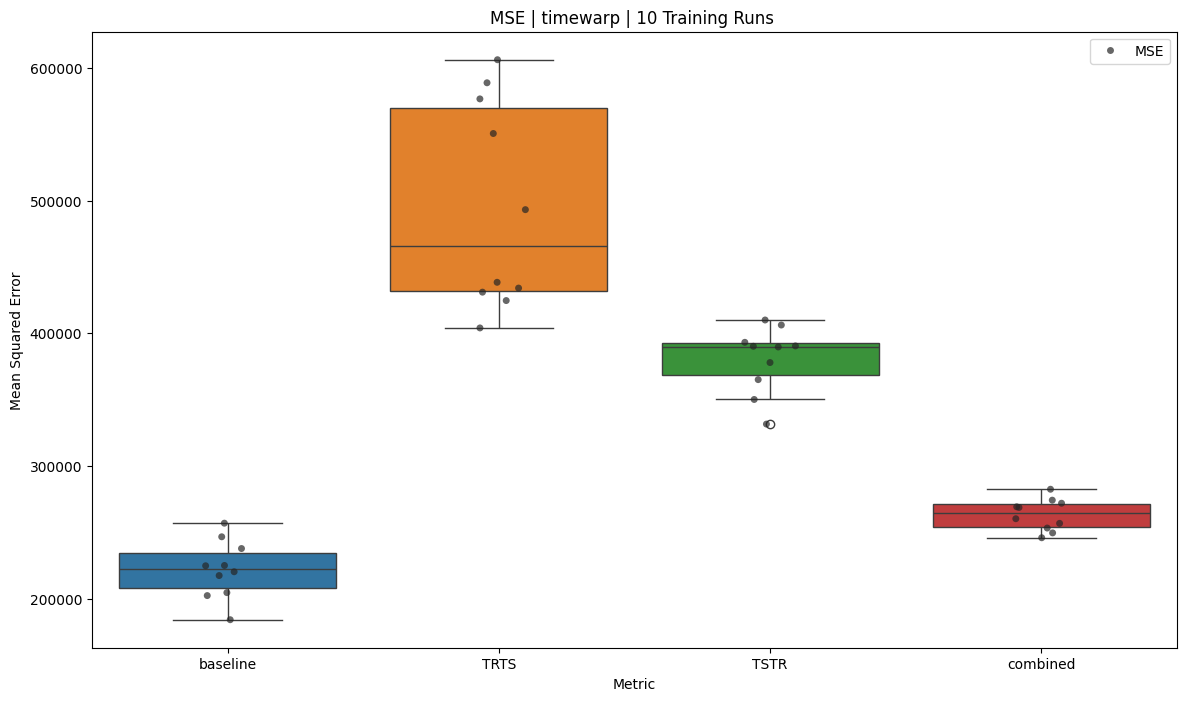

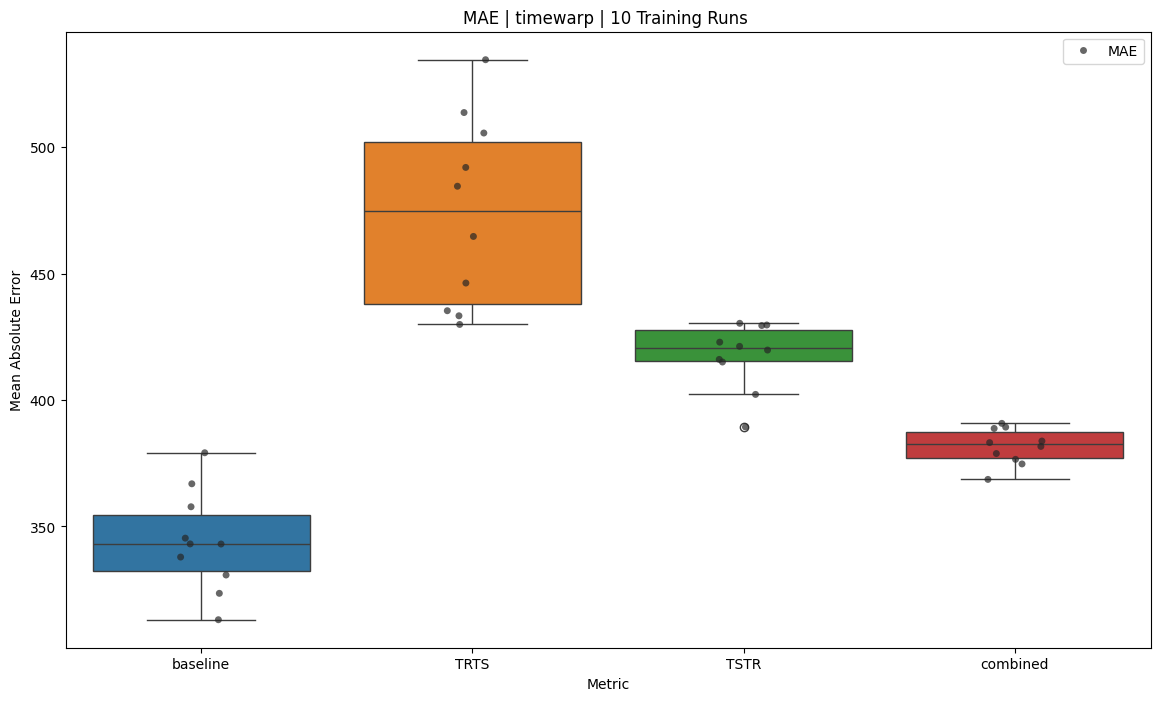

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Visualize Synthetic vs Real Data

In [13]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


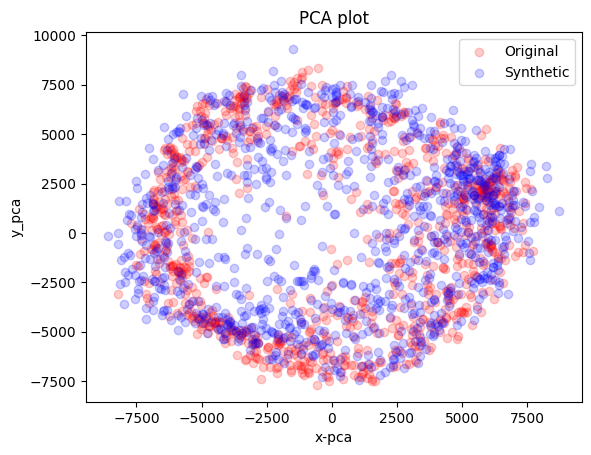

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.189s...


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1207.028792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.769028
[t-SNE] KL divergence after 300 iterations: 1.070423


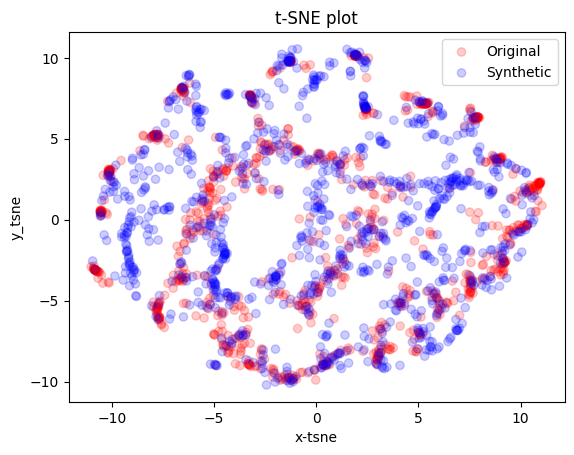

In [14]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.